# Example Exploration of Mapped Data

This notebook provides a simple set of examples of things to do with the mapped data products from the `PINK SOM`. It aims to demonstrate how to use some of the example classes and perform basic transformations and clustering. Not meant to be a be-all-end-all cookbook. 

In [1]:
import pickle 
import os, shutil

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
from tqdm import tqdm
from scipy.ndimage import rotate
from scipy.stats import gaussian_kde
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.table import Table
from astropy.coordinates import SkyCoord, search_around_sky
import astropy.units as u

import pyink as pu


## Datasets

A set of SOMs were trained against ~24,000 images with images from EMU and WISE W1 surveys. The input image size was 5 arcminutes. Below are the base file names that will be used to load in:
- preprocessed training images provided to PINK
- the SOM, mapping and spatial transform data files produced by PINK

The `PathHelper` is a simple utility class to help make folders and sub-folders without to much difficulty. 


In [2]:
path = pu.PathHelper('Example_Images', clobber=True)
suffix = 'B3Circular_h8_w8_emu.bin'
image_binary = 'EMU_WISE_E95E05_Aegean_Components_Complex_islandNorm_Log_Reprojected.bin'

(2, 1, 0, 0, 2, (8, 8), 0, 3, (2, 213, 213))
(2, 1704, 1704)


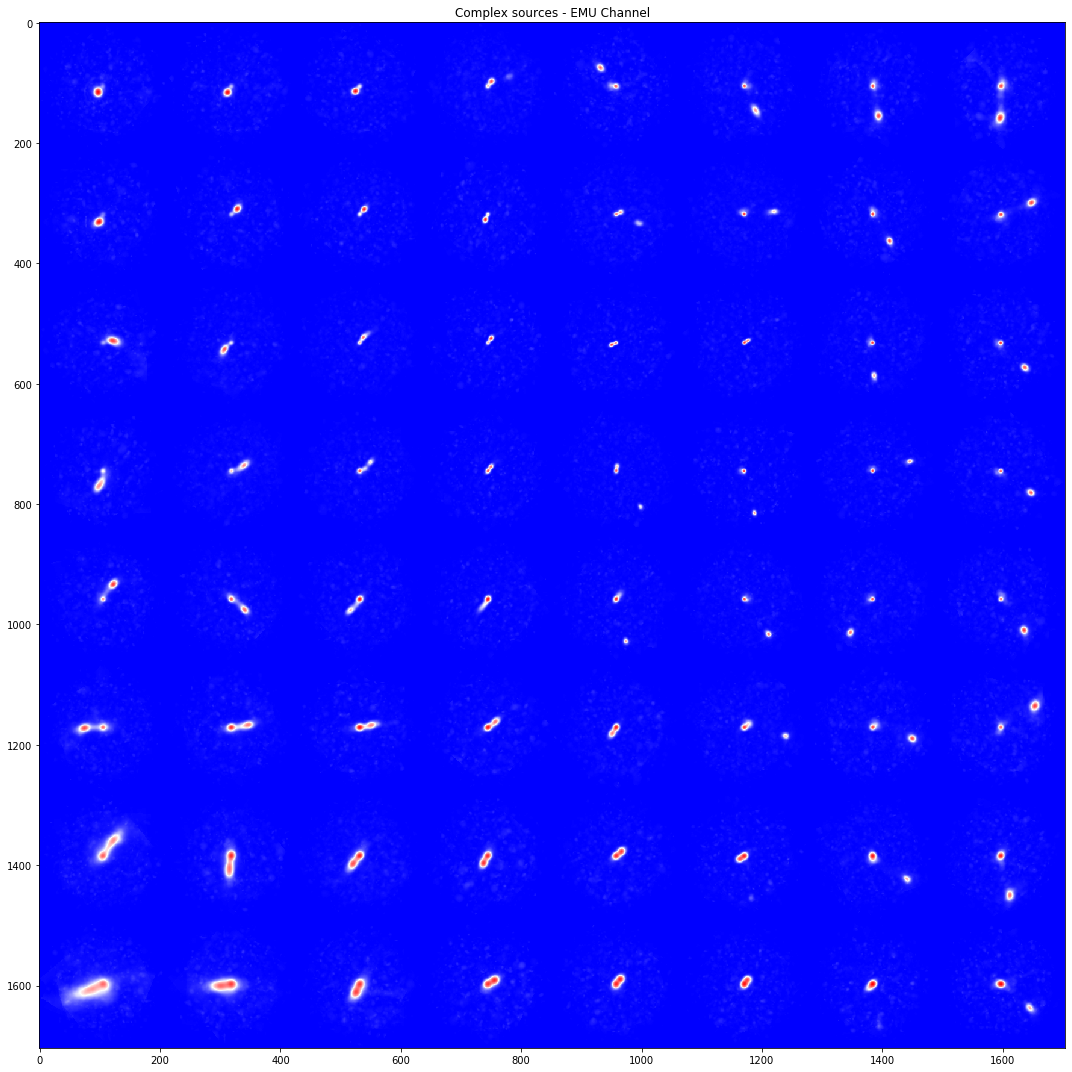

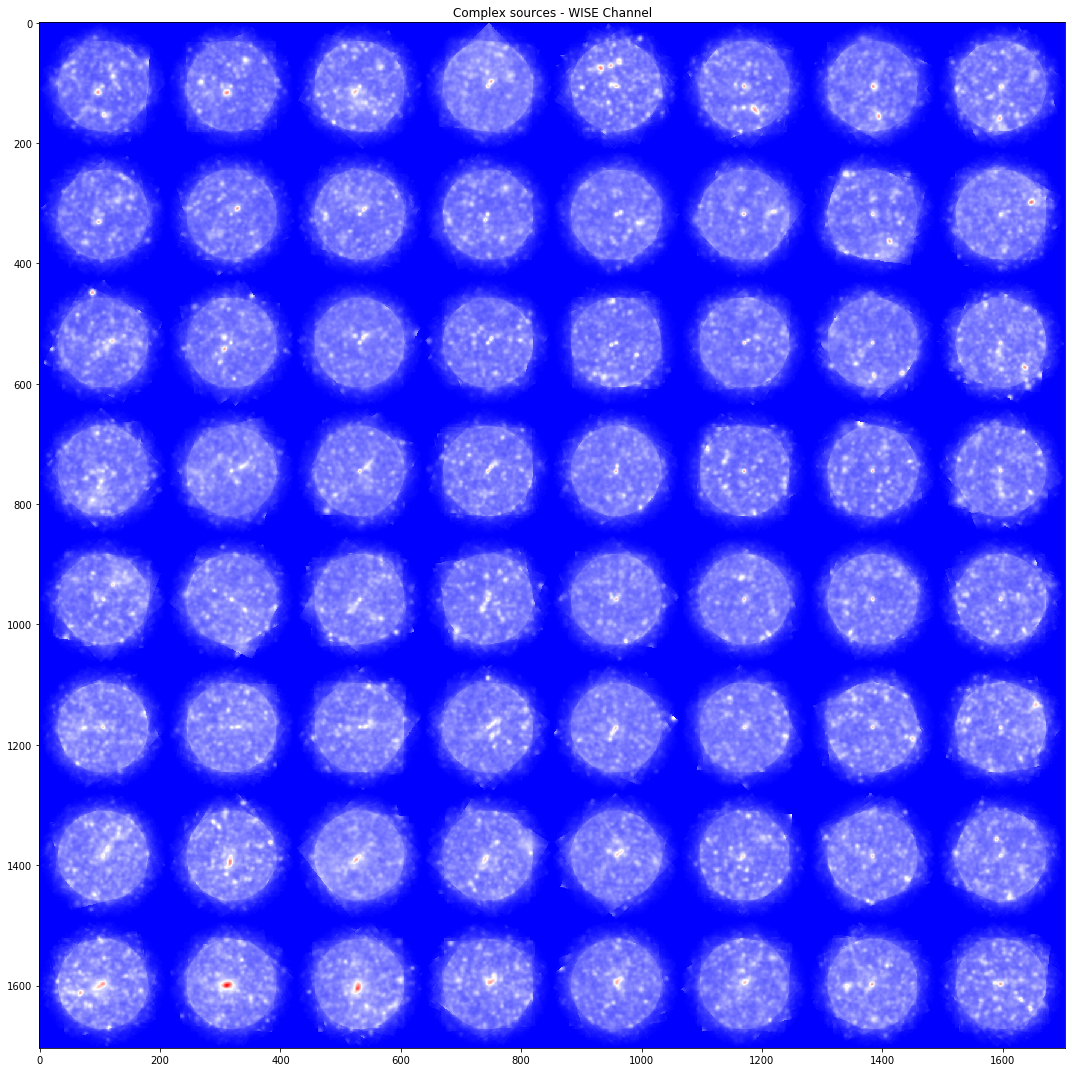

In [3]:
som = pu.SOM(f'SOMs/SOM_{suffix}')

print(som.header)
print(som.data.shape)

d = som.data.copy()

fig, ax = plt.subplots(1,1,figsize=(15,15))

ax.imshow(np.squeeze(d[0,:,:]), cmap='bwr')

ax.set_title('Complex sources - EMU Channel')
fig.tight_layout()
fig.savefig(f'{path}/EMU_Complex_EMU_Channel.png')

fig, ax = plt.subplots(1,1,figsize=(15,15))

ax.imshow(np.squeeze(d[1,:,:]), cmap='bwr')

ax.set_title('Complex sources - WISE Channel')
fig.tight_layout()
fig.savefig(f'{path}/EMU_Complex_WISE_Channel.png')



The code in the cell below will iterate over each neuron and make a corresponding figure. Note that although the input images were 5 arcminutes (150 pixels), each neuron comes out as 213x213 pixels. By default `PINK` will try to retain as much information as possible, including the outmost region where there will be inconsist image coverage that varies depending on the adopted spatial transform solution. 

In [4]:
plt.close('all')

for i, k in enumerate(som):
    d = som[k].copy()

    d[d.min() == d] = np.nan
    
    fig, ax1 = plt.subplots(1,1)

    ax1.imshow(np.squeeze(d[0, :,:]), cmap='bwr')        
   
    ax1.set(title=k)

    fig.tight_layout()
    fig.savefig(f"{path.neurons}/{k}.png")
    plt.close(fig)
    
print('Done')

Done


Below we load in the mapping and spatial transform solution produced by `PINK` and create a handle to access the corresponding preprocess image binary file. 

In [5]:
transform = pu.Transform(f'SOMs/TRANSFORM_{suffix}')
print(transform.header)
print(transform.data.shape)
print('---\n')

mapper = pu.Mapping(f'SOMs/MAP_{suffix}')
print(mapper.header)
print(mapper.data.shape)
print(mapper.bmu().shape)
print('---\n')

imgs = pu.ImageReader(image_binary, record_path='EMU_WISE_E95E05_Aegean_Components_Complex_islandNorm_Log_Reprojected.bin.order.pkl')
print(imgs.header)
print(imgs.data.shape)
print('---\n')


(2, 3, 21437, 0, 2, (8, 8))
(21437, 8, 8)
---

(2, 2, 0, 21437, 0, 2, (8, 8))
(21437, 8, 8)
(21437, 2)
---

(2, 0, 0, 21437, 0, 3, (2, 150, 150))
(21437, 2, 150, 150)
---



# Weird images

As part of `PINK` a measure of similarity is calculated between each image an each neuron. As the SOM is constructed to represent the predominate features in a training dataset, outliers may efficently be mined by search for images that had a poor similarity. This may be refined by sorting images based on their similarity to their best matching neuron (i.e. images where even the most similar neuron is still a bad match). Below are the top 100 preprocessed images that had the worst similarity measure out of the training dataset. Since there has been no collation procedure applied yet some structures may be repeated more than once is there were more than one component in the component catalogue within the same island of emission. 

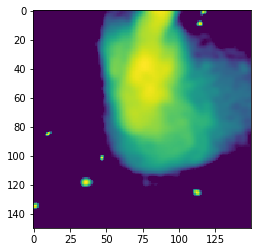

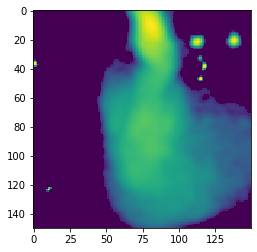

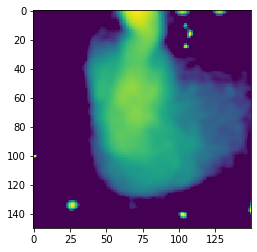

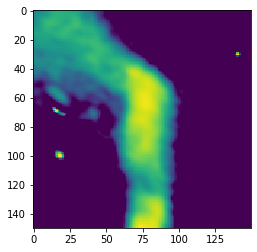

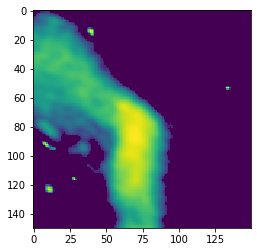

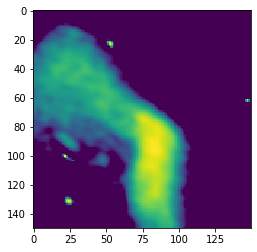

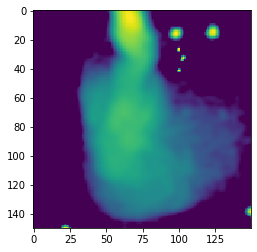

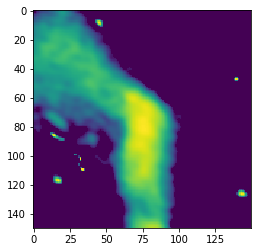

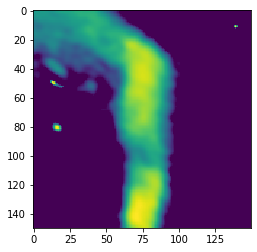

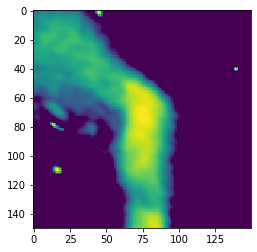

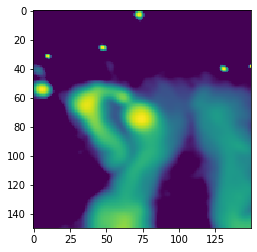

In [6]:
plt.close('all')

bad = mapper.data.reshape(mapper.data.shape[0],-1)
bad = bad.min(axis=1)
args = bad.argsort()

for i, idx in enumerate(args[::-1]):
    if i > 10:
        break
    
    fig, ax1 = plt.subplots(1,1)
    
    ax1.imshow(imgs.data[idx, 0])
    
    fig.savefig(f"{path.Weird}/weird_{i}.pdf")

# Transforming between Sky-Coordinates and neurons

A critical component of using the SOM to segment out related and unrelated features is the ability to transform sky-coordinate positions to neuron pixels positions. For each image first nearby positions within catalogue space must first be identified (i.e. for each center position across all images, find nearby catalogue positions). Then these much be transforms to pixel coordinates within an image and then transformed (with the spatial transformation solution returned by `PINK`) into the neuron reference frame.

In [13]:
catalogue = Table.read('../Data/10_field_emu/aegean/aegean_comp.fits').to_pandas()

catalogue['uuid'] = catalogue['uuid'].str.decode("utf-8")

catalogue

,island,source,background,local_rms,ra_str,dec_str,ra,err_ra,dec,err_dec,...,err_b,pa,err_pa,flags,residual_mean,residual_std,uuid,psf_a,psf_b,psf_pa
0,1,0,2.735007e-06,0.000063,b'22:16:30.58',b'-63:01:26.45',334.127411,0.000031,-63.024014,0.000008,...,0.055042,-61.205288,0.298315,0,-6.266882e-06,0.000074,17faf6f9-0d47-4faa-9bc8-c8581dc72f49,14.78397,11.051587,-59.004898
1,2,0,-8.031109e-07,0.000061,b'22:15:13.15',b'-63:04:28.70',333.804779,0.000484,-63.074638,0.000108,...,1.199520,27.375042,2.564502,0,-3.090008e-06,0.000008,e786514c-a154-4c23-bcbe-c13ff45d0935,14.78397,11.051587,-59.004898
2,3,0,-2.616467e-06,0.000060,b'22:16:05.38',b'-63:01:14.67',334.022400,0.000115,-63.020741,0.000028,...,0.217276,-60.033047,0.843523,0,-5.192538e-06,0.000050,86eeb9f9-fb3c-4703-8657-1800d758d528,14.78397,11.051587,-59.004898
3,4,0,1.788521e-06,0.000062,b'22:17:25.58',b'-62:57:46.30',334.356598,0.000030,-62.962860,0.000009,...,0.042448,-59.288612,0.015803,0,-3.987740e-05,0.000311,faaa3d9d-79c3-4fbe-87fc-094bc8419816,14.78397,11.051587,-59.004898
4,5,0,3.743040e-06,0.000062,b'22:17:33.75',b'-62:57:38.63',334.390625,0.000372,-62.960732,0.000088,...,0.810359,28.507483,1.088374,0,-1.395770e-06,0.000010,34443f11-2d6e-4a38-9cd0-d0a0c305d7d4,14.78397,11.051587,-59.004898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251540,241146,0,4.826535e-06,0.000075,b'20:40:07.02',b'-48:14:02.38',310.029266,0.000186,-48.233994,0.000052,...,0.205064,-60.575142,1.007008,0,-5.707773e-07,0.000015,13f99809-5553-4e21-a80a-d807d66147cb,14.78397,11.051587,-59.004898
251541,241147,0,-1.538268e-06,0.000068,b'20:47:44.94',b'-48:13:42.58',311.937225,0.000468,-48.228493,0.000106,...,0.595964,-60.183002,0.790698,0,-1.184319e-06,0.000010,b2b53daf-1ebd-4bd3-a42f-dbc302b1da5c,14.78397,11.051587,-59.004898
251542,241148,0,-1.310643e-05,0.000070,b'20:43:14.11',b'-48:14:00.87',310.808777,0.000487,-48.233574,0.000228,...,1.401948,32.186440,0.322078,0,-1.635617e-05,0.000041,4f0fd1db-31c8-4c6c-a115-3700485b98ad,14.78397,11.051587,-59.004898
251543,241149,0,-5.591048e-06,0.000070,b'20:34:15.10',b'-48:12:16.39',308.562927,0.000200,-48.204552,0.000066,...,0.288276,34.057232,0.526203,0,-1.807150e-05,0.000059,4808f445-c4f7-4346-9f8f-131cb1296ed0,14.78397,11.051587,-59.004898


In [14]:
uuid_keys = [i for i in imgs.records]

emu_positions = SkyCoord(catalogue['ra']*u.deg, catalogue['dec']*u.deg)

# Reorders catalogue to the order images went into PINK image file
sub_cata = catalogue.set_index(keys='uuid',).loc[uuid_keys]

sky_positions = SkyCoord(sub_cata['ra']*u.deg, sub_cata['dec']*u.deg)

In [15]:
sky_matches = search_around_sky(sky_positions, sky_positions, seplimit=5*u.arcminute/2)
emu_sky_matches = search_around_sky(sky_positions, emu_positions, seplimit=5*u.arcminute/2)

0 (0, 0) 351
1 (0, 1) 333
2 (0, 2) 512
3 (0, 3) 126
4 (0, 4) 646
5 (0, 5) 441
6 (0, 6) 362
7 (0, 7) 419
8 (1, 0) 337
9 (1, 1) 323
10 (1, 2) 371
Done


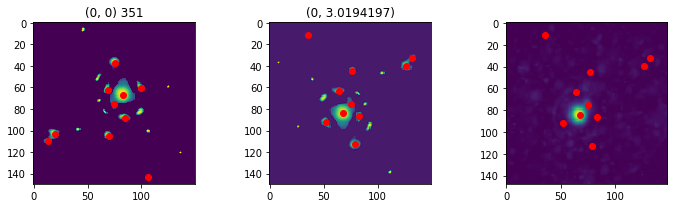

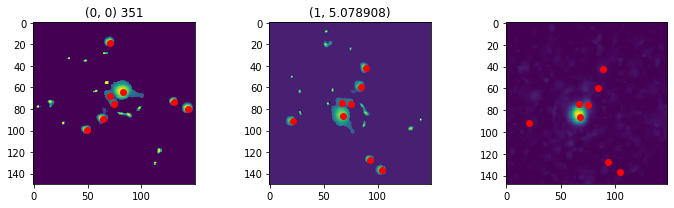

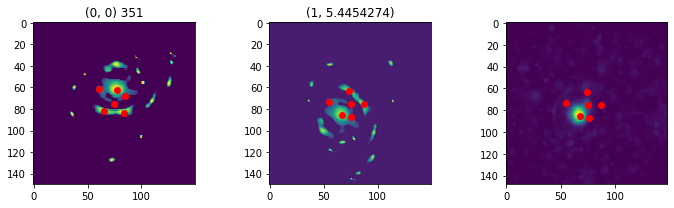

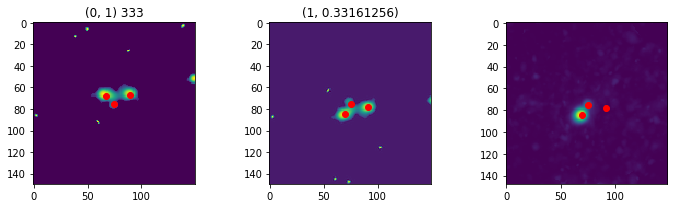

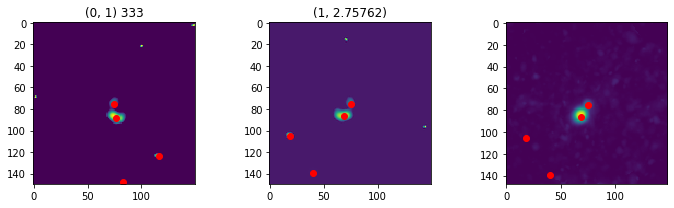

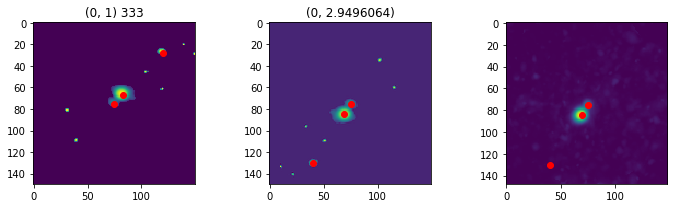

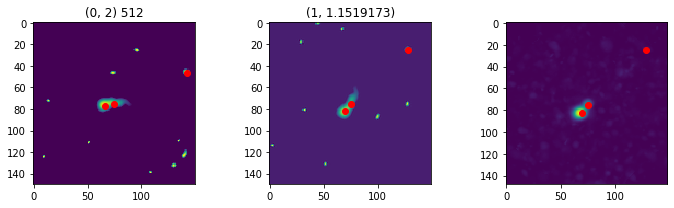

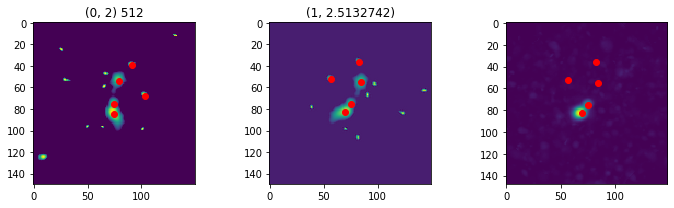

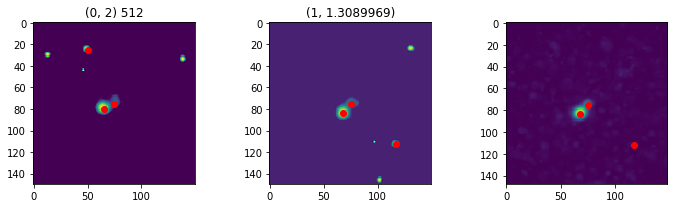

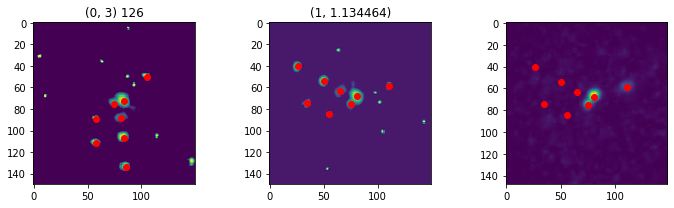

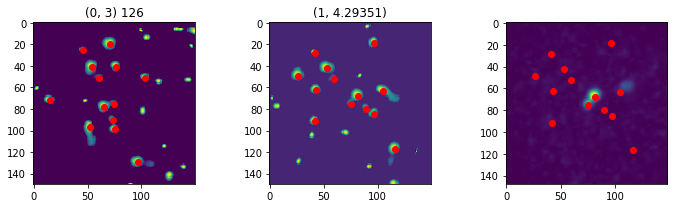

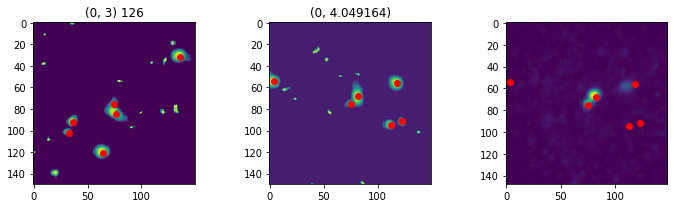

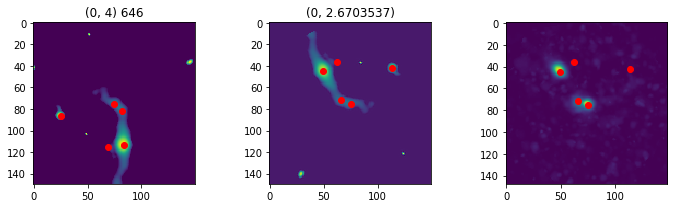

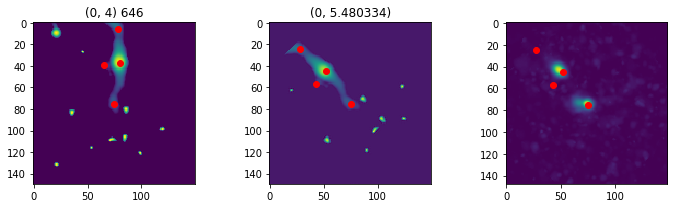

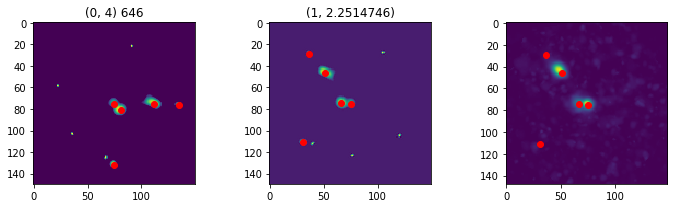

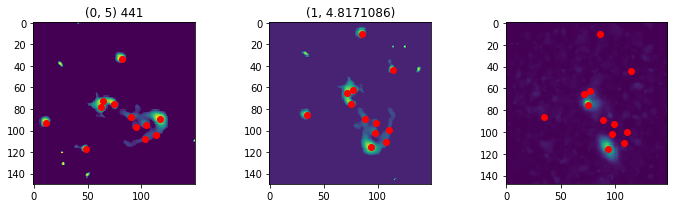

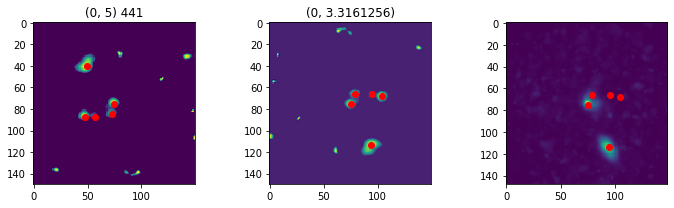

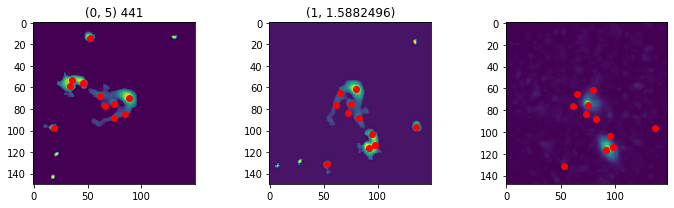

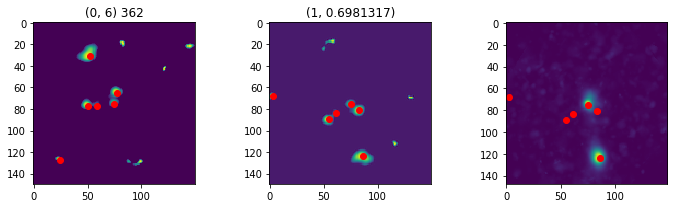

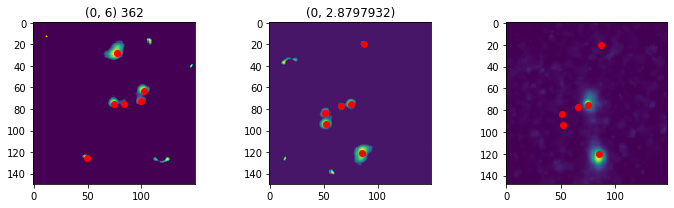

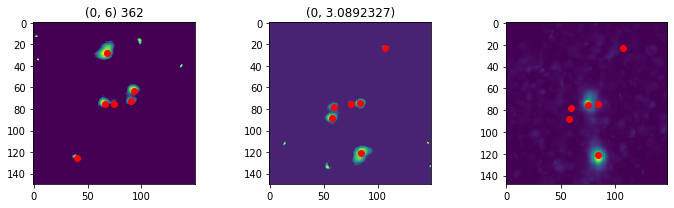

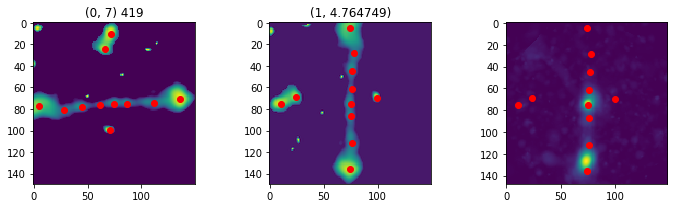

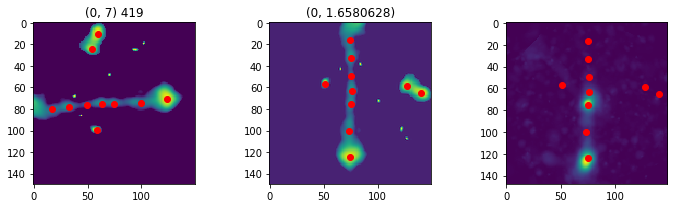

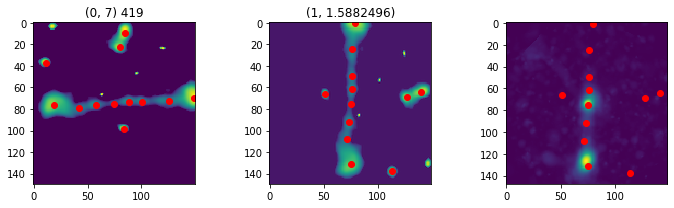

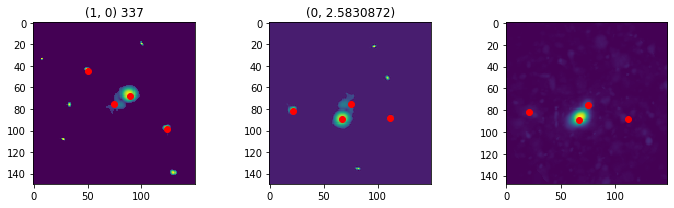

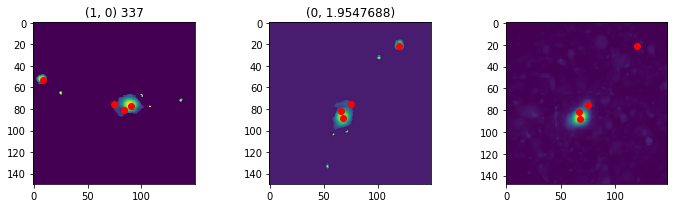

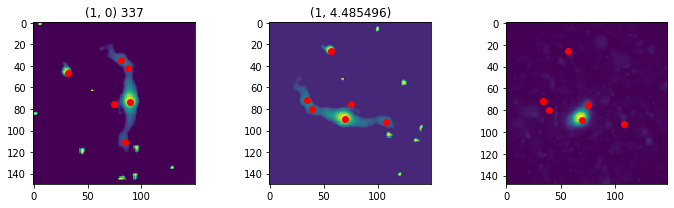

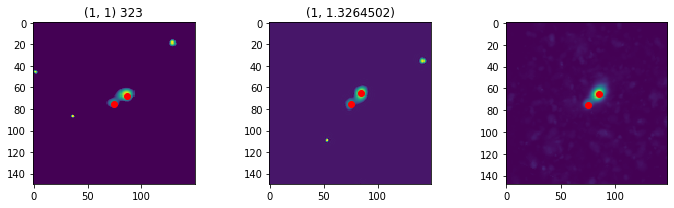

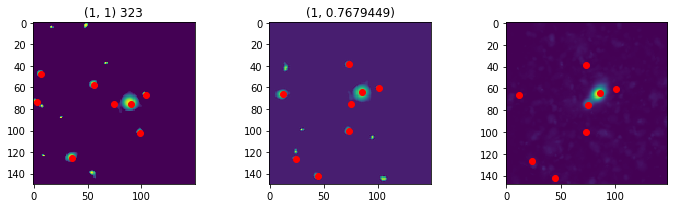

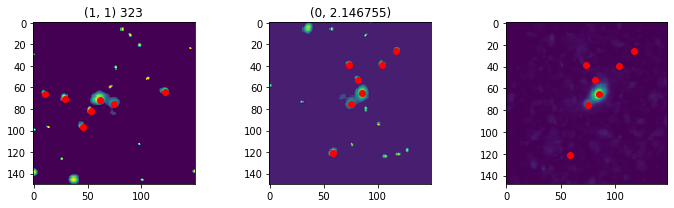

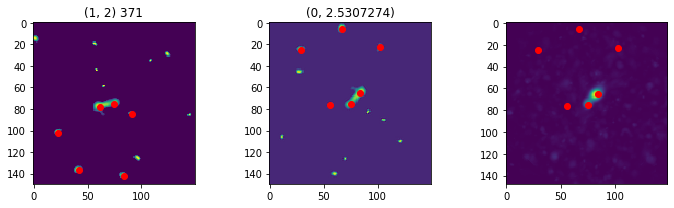

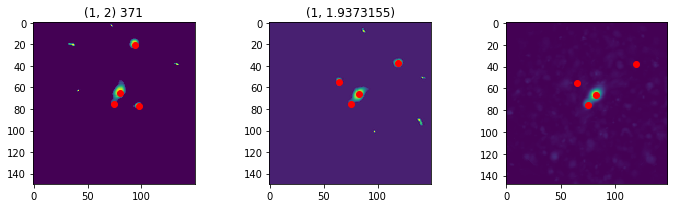

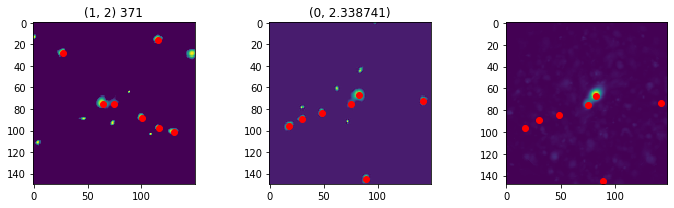

In [16]:
plt.close('all')

bmu_keys = mapper.bmu(return_idx=True, squeeze=True)
bz, by, bx = bmu_keys.T

for i, k in enumerate(som):   
    if i > 10:
        break
        
    mask = ((k[0] == by) & (k[1] == bx))
    argmask = np.argwhere(mask)

    print(i, k, np.sum(mask))
    
    for j, src in enumerate(argmask):
        if j > 2:
            break
        
        src = src[0]
        
        center_pos = sky_positions[src]
        src_mask = src == sky_matches[0]
        src_matches = sky_matches[1][src_mask]   
        
        emu_mask = src == emu_sky_matches[0]
        emu_matches = emu_sky_matches[1][emu_mask]
        
        bmu_min = k
        
        mapper_bmu =  tuple(mapper.bmu(src))
        assert bmu_min == mapper_bmu
        
        trans_key = (src, *k)
        flip, angle = transform.data[trans_key]
        src_transform = (flip, angle)
        
        wcs_custom = imgs.records[src][1]
        
        spatial_emu_pos = pu.CoordinateTransformer(center_pos,
                                               emu_positions[emu_matches],
                                               src_transform,
                                                pixel_scale=2*u.arcsecond)
        
        src_img = imgs.data[src, 0].copy()
        transform_img = pu.pink_spatial_transform(src_img, src_transform)
    
        fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize=(10, 3))
        
        ax.imshow(src_img)
        ax1.imshow(transform_img)
        ax2.imshow(som[k][0][32:-33, 32:-33])

        ax.plot(spatial_emu_pos.coords['offsets-pixel'][0].value + 75, 
                spatial_emu_pos.coords['offsets-pixel'][1].value + 75,
                'ro')
        
        ax1.plot(spatial_emu_pos.coords['offsets-neuron'][0].value + 75, 
                spatial_emu_pos.coords['offsets-neuron'][1].value + 75,
                'ro')
        
        ax2.plot(spatial_emu_pos.coords['offsets-neuron'][0].value + 75, 
                spatial_emu_pos.coords['offsets-neuron'][1].value + 75,
                'ro')
        
        
        ax.set(title=f"{k} {np.sum(mask)}")
        ax1.set(title=f"{src_transform}")
        
        fig.tight_layout()
        fig.savefig(f'{path.Overlay}/{k}_{j}.png')
        
        
print('Done')

# Collecting results

For any one neuron there will be many images (and hence regions of the sky) that best match to it. Each of these images will have a *random* spatial transform to align it onto the neuron, and also a set of *random* nearby galaxies with respect to the center subject galaxy. The SOM attempts to recognise consistent features among the input training images while creating the neurons. If we were to cluster catalogue information intelligently based on (1) the best matching neuron and (2) appropriate spatial transform solution, then there should be an excess of catalogued sources coincident with the features within the neurons. If this is the case (it is), then the reduced data dimension space constructed by `PINK` could be used as a tool to help classification of catalogue space information. Annotating information on a neuron at the pixel level may be transfered back onto an image and the corresponding components in a catalogue.

Note that only the first ten clustered images are made below. 

In [ ]:
plt.close('all')

bmu_keys = mapper.bmu(return_idx=True, squeeze=True)
bz, by, bx = bmu_keys.T

for i, k in enumerate(som): 
    if i > 10:
        break
        
    mask = ((k[0] == by) & (k[1] == bx))
    argmask = np.argwhere(mask)

    if np.sum(mask) == 0:
        continue
    
    print(i, k, np.sum(mask))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
    
    ax1.imshow(som[k][0], cmap='Greys')
    ax2.imshow(som[k][0], cmap='Greys')
    
    ax1.set(title=f"{k} - {np.sum(mask)}")
    
    divider = make_axes_locatable(ax2)
    axHistx = divider.append_axes('top', size='23%', pad='2%', sharex=ax2)
    axHisty = divider.append_axes('right', size='23%', pad='2%', sharey=ax2)
    
    spatial_pos = []
    
    for j, src in enumerate(argmask):        
        src = src[0]
        
        center_pos = sky_positions[src]
        src_mask = src == sky_matches[0]
        src_matches = sky_matches[1][src_mask]   
        
        emu_mask = src == emu_sky_matches[0]
        emu_matches = emu_sky_matches[1][emu_mask]
        
        bmu_min = k
        
        mapper_bmu =  tuple(mapper.bmu(src))
        assert bmu_min == mapper_bmu
        
        transform_key = (src, *k)
        src_transform = transform.data[transform_key]
        flip, angle = src_transform

        spatial_emu_pos = pu.CoordinateTransformer(center_pos,
                                               emu_positions[emu_matches],
                                               src_transform,
                                                pixel_scale=2*u.arcsecond)
        
        spatial_pos.append(spatial_emu_pos)
        

    px = np.concatenate([pos.coords['offsets-neuron'][0].value for pos in spatial_pos]).flatten() + 213/2
    py = np.concatenate([pos.coords['offsets-neuron'][1].value for pos in spatial_pos]).flatten() + 213/2
    
    ax2.plot(px, 
             py,
             'ro',
             markersize=1.,
            alpha=0.1)
        
    axHistx.hist(px, bins=30, density=True, histtype='stepfilled', alpha=0.7)
    axHisty.hist(py, bins=30, density=True, orientation='horizontal', histtype='stepfilled', alpha=0.7)
    axHistx.set(ylabel='Density')
    axHisty.set(xlabel='Density')
    
    # no labels
    plt.setp(axHistx.get_xticklabels(), visible=False)
    plt.setp(axHisty.get_yticklabels(), visible=False)
    
    fig.tight_layout()
    fig.savefig(f'{path.Cluster}/{k}_cluster.png')

            
print('Done')

0 (0, 0) 351
1 (0, 1) 333
2 (0, 2) 512
3 (0, 3) 126
4 (0, 4) 646
5 (0, 5) 441
